# Rainfall Prediction Classifier

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

## Load the data


In [12]:
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [13]:
df.count()

Date             145460
Location         145460
MinTemp          143975
MaxTemp          144199
Rainfall         142199
Evaporation       82670
Sunshine          75625
WindGustDir      135134
WindGustSpeed    135197
WindDir9am       134894
WindDir3pm       141232
WindSpeed9am     143693
WindSpeed3pm     142398
Humidity9am      142806
Humidity3pm      140953
Pressure9am      130395
Pressure3pm      130432
Cloud9am          89572
Cloud3pm          86102
Temp9am          143693
Temp3pm          141851
RainToday        142199
RainTomorrow     142193
dtype: int64

### Drop all rows with missing values

In [15]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3p

In [16]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

## Data leakage considerations

In [18]:
df = df.rename(columns={'RainToday': 'RainYesterday',
                        'RainTomorrow': 'RainToday'
                        })

## Location selection

In [20]:
df = df[df.Location.isin(['Melbourne','MelbourneAirport','Watsonia',])]
df. info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

## Extracting a seasonality feature

In [22]:
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return 'Summer'
    elif (month == 3) or (month == 4) or (month == 5):
        return 'Autumn'
    elif (month == 6) or (month == 7) or (month == 8):
        return 'Winter'
    elif (month == 9) or (month == 10) or (month == 11):
        return 'Spring'

In [23]:
df['Date'] = pd.to_datetime(df['Date'])
df['Season'] = df['Date'].apply(date_to_season)
df=df.drop(columns="Date")

In [24]:
df.sample(5)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainToday,Season
70141,Melbourne,9.8,18.9,9.8,2.2,9.4,NNW,39.0,WNW,W,...,36.0,1008.2,1007.7,1.0,6.0,12.5,17.5,Yes,No,Spring
68203,Melbourne,13.8,19.8,0.0,5.0,7.6,S,48.0,SW,S,...,39.0,1027.3,1026.9,6.0,2.0,14.9,18.6,No,No,Autumn
64519,MelbourneAirport,12.6,26.8,0.0,6.4,8.8,SSE,33.0,E,SE,...,38.0,1022.1,1018.4,5.0,5.0,18.7,25.4,No,Yes,Spring
70359,Melbourne,12.8,19.3,0.0,5.2,4.8,NNW,33.0,N,N,...,58.0,1017.5,1013.5,7.0,1.0,15.9,18.6,No,No,Autumn
66416,MelbourneAirport,6.0,22.5,0.0,2.8,9.0,N,78.0,NNW,N,...,34.0,1015.7,1009.9,5.0,1.0,13.5,21.9,No,Yes,Autumn


In [25]:
X = df.drop(columns='RainToday', axis=1)
y = df['RainToday']

In [26]:
y.value_counts()

RainToday
No     5766
Yes    1791
Name: count, dtype: int64

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Define preprocessing transformers for numerical and categorical features

In [29]:
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()  
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [30]:
# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode the categoricals 
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [32]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [33]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

In [34]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [54]:
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=1)  
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pr...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainYesterday',
                                                                          'Season'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=1)

In [58]:
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best cross-validation score: 0.85


In [60]:
test_score = grid_search.score(X_test, y_test)  
print("Test set score: {:.2f}".format(test_score))

Test set score: 0.84


In [62]:
y_pred = grid_search.predict(X_test)

In [63]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.94      0.90      1154
         Yes       0.74      0.51      0.60       358

    accuracy                           0.84      1512
   macro avg       0.80      0.73      0.75      1512
weighted avg       0.83      0.84      0.83      1512



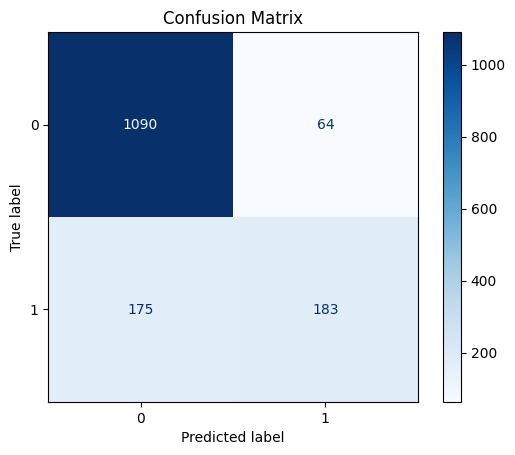

In [64]:
## Write your response.
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Feature importances

In [69]:
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

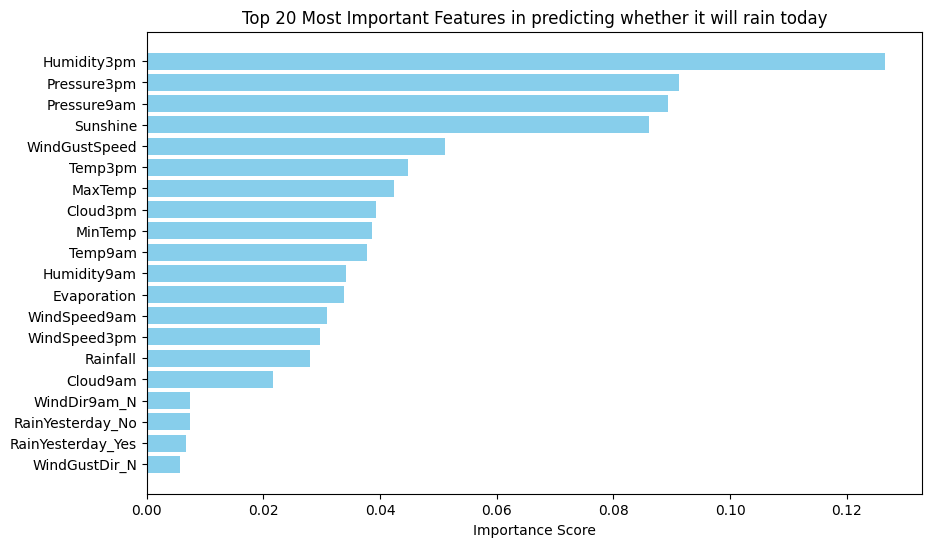

In [71]:
feature_names = numeric_features + list(grid_search.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

feature_importances = grid_search.best_estimator_['classifier'].feature_importances_



importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)
N = 20
top_features = importance_df.head(N)


plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top {N} Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show()

## Try another model

In [73]:
pipeline.set_params(classifier=LogisticRegression(random_state=42))
grid_search.estimator = pipeline

param_grid = {'classifier__solver' : ['liblinear'], 'classifier__penalty': ['l1', 'l2'], 'classifier__class_weight' : [None, 'balanced']}
grid_search.param_grid = param_grid

grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


              precision    recall  f1-score   support

          No       0.86      0.93      0.89      1154
         Yes       0.68      0.51      0.58       358

    accuracy                           0.83      1512
   macro avg       0.77      0.72      0.74      1512
weighted avg       0.82      0.83      0.82      1512



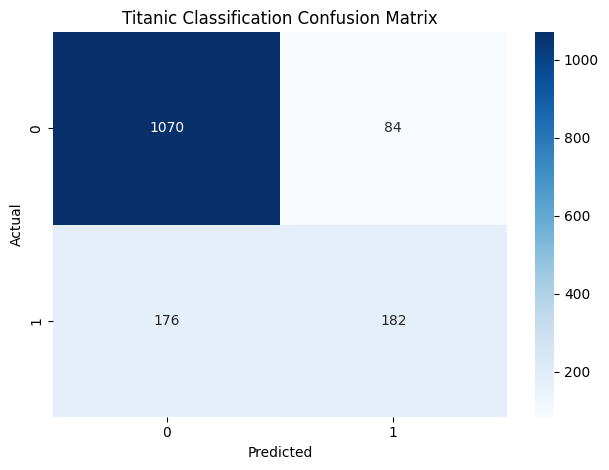

In [75]:
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()